In [1]:
'''this notebook heavily refers to the post https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/'''

'this notebook heavily refers to the post https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/'

## How this Notebook works:

This notebook contains a large amount of Danish texts, that you can use to do topic modeling (explained below). You can find a list of the authors and texts [here](https://github.com/digitaltxtlab/CLEAR/blob/master/ADL/metadata/metadata_adl.csv). 
It's not possible to add your own texts to this notebook. If you want to do topic modeling with your own data, please use one of the other notebooks. You can find the other notebooks here (add link).

To use this notebook, follow the steps from top to bottom. We added explanations at each step to make it easier for you to use. If you need more help, take a look at the video tutorial. It will walk you through each step. You can find it here (add link).

## Overview of Topic Modeling

Before using topic modeling to explore our data set, let's first look at the definition of Topic Modelling. 

*If you are not very familar with the techniques about preprocessing, you can find a separate notebook introducing these ideas [here](https://github.com/digitaltxtlab/CLEAR/blob/master/notebook/TextNormalizationAndRegularExpression.ipynb).*

### What is Topic Modeling

Topic modeling is a technique used in the Natural Language Processing (nlp) context to discover the latent semantic structures in the text. Although it is very tempting to think of it as a magic tool to extract the topic from the text, **topic modeling** actually has very specific definition and should be used properly.

Here we use the definition from the book *Speech and Language Processing*: "topic modeling is used to induce sets of associated words from text using unsupervised learning. For example, this set of words {waiter, dishes, chef, plate} is associated and often appear at the same time in text."

More rigoriously, topic can be defined as the **probability distribution over words**.

Another task which is easily confused with topic modelling is **text classification**. In that task, we need to assign a label to a given text. For example, figure out if a poem is about history or religion. The main difference is that, in topic modeling, the output is a set of words which represent an unknown topic(e.g. {waiter, dishes ...}), while in text classification, the output is a single label (e.g. history).

### How to use topic modeling 

Topic modeling is very useful when it is used to provide some insight to the reader about a large amount of text. By looking at the output of the results, you can see how many potential topics there are, and then by looking at the words contained in each topic, you can have a vague idea for what this topic is about. 

### *(Aside issue) Implementation of topic modeling*

In this script, we use a common algorithm called *Latent Dirichlet Allocation (LDA)* to implement topic modeling. It is important to note that this method may require substantial *math.* background. 

In case anyone is interested, I put the link to the original paper [here](http://www.robotics.stanford.edu/~ang/papers/jair03-lda.pdf).

## Content

In this notebook you will do the following things:
1. Import the libraries
2. Preprocess the text(s)
    * Prepare stopwords
    * Select author or text(s)
    * Clean the text(s) - tokenizing
    * Remove stopwords
    * Form bigrams
3. Apply LDA algorithm (= topic modeling algorithm)
4. Explore the results
    * Evaluate quality of the results
    * Interact with results dynamically
    * Visualize topic distribution for a single passage
    * Find dominant topic in each sentence
    * Find most representative document for each topic
    * Find topic distribution across documents

# Step 1: Import the libraries

In order to use this notebook properly, you have to have Anaconda installed on you computer. Find a tutorial on how to install Anaconda here (add link). 

You may need to install the following libraries to run the analysis. In order to install these libraries you copy each code "conda install -c anaconda gensim" and paste it into your terminal window, then press enter. You can find more instructions on how to do that here (add link).

- gensim 
    - conda install -c anaconda gensim
- nltk 
    - conda install -c anaconda nltk
- pyLDAvis
    - conda install -c conda-forge pyldavis
    - conda install -c conda-forge/label/gcc7 pyldavis

Note: The first command "conda install -c conda-forge pyldavis" will work in most cases, but in some versions of Anaconda, you have to use the second command "conda install -c conda-forge/label/gcc7 pyldavis", which specifies the label of this package. 

In [2]:
import nltk
#nltk.download('stopwords')
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

#for Stemming
from nltk.stem.snowball import DanishStemmer

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

C:\Users\ljh\Anaconda3\lib\site-packages\gensim\utils.py:1209: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [3]:
import os,sys
parentPath = os.path.join(os.path.dirname(os.getcwd()),"tools")
sys.path.insert(0, parentPath)
from scripts_py import preprocessing as pre

# Step 2: Preprocess the text(s)

## a. Prepare Stopwords

We have added a list of stop words from the nltk library. This list is relatively short. 

It is possible to add your own list of stopwords in the field below. Your own list goes into the brackets of "stop_words.extend". Each word needs to be added in single quotation marks **'word'** and separated by a comma and a space: **'word', 'next',**

Do you want to see which words already are in the stopwords list? 

Follow this link to see the [list](https://github.com/digitaltxtlab/CLEAR/blob/master/notebook/stopwordsList.txt). 
Alternatively, if you are comfortable writing into the codefield, you can click into the field below. Create a new line a the bottom and write **stop_words**. Then click run. This should show you a list of stopwords. 


In [1]:
from nltk.corpus import stopwords
stop_words = stopwords.words('danish')
stop_words.extend(['paa','ved','saa','den'])

## b. Select author or text(s)

You can select any author by last name. You can find a list of all available authors and texts here (add link) or in this file here: ADL/metadata/metadata_adl.csv file (the available name is the second column).

You can choose from **75 Danish Authors** and a total of over **8500 Danish texts**.

In [10]:
import codecs
def creat_file_list(author_name):
    """this function is used to get the list of articles of a given author"""
    file_list=['non']
    cwd=os.getcwd()
    parent_path = os.path.dirname(cwd)
    des_pos=os.path.join(parent_path,"ADL","metadata","metadata_adl.csv")
    fh=codecs.open(des_pos,'r','utf-8')
    for line in fh.readlines():
        L=line.split(",")
        if(re.search(author_name,L[1])):
            temp_string=L[0]+".txt"
            file_list.append(temp_string)
    return file_list[1:]
def read_articles(articles):
    """this function read in articles and return content"""
    data = list()
    for ele in articles:
        article = os.path.join(os.path.dirname(os.getcwd()),"ADL","plain",ele)
        with open(article, encoding ="utf-8") as f:
            lines = f.readlines()
        data.append( ' '.join(lines))
    return data

*The code below read all the articles of Grundtvig and stores them into data.*

**How to select another author:**

In the field below you have a command that says *author = ""*. Write the name of the author inside the quotation marks. 

For example:

author = "Kierkegaard"



In [11]:
author = "Knud Hjortø"
articles = creat_file_list(author)
data = read_articles(articles)

If you don't want all the articles but only specifc articles, you can specify it here.

**How to select article(s):**

In the field below in the square brackets write the work-id of the article (see list) in quotation marks and separate them with a comma and a space. Remember to add *.txt* at the end of each work-id

For example:

articles = ["kierkegaard03val_workid54108.txt","kierkegaard01val_workid54239.txt","aakjaer01val_workid55662.txt"]

**Please note:** if there is a **#** at the beginning of a line, it means that this function is disabled. To enable the function, remove the **#**.

Similarly, if you want to disable another function, add **#** at the beginning of the line.
If you want to analyze specific articles, but not all the works of one author, please add **#** at the beginning of each line in the field above.

In [12]:
#articles = ["aare01val_workid69870.txt","aakjaer01val_workid55565.txt","aakjaer01val_workid55662.txt" ,"aakjaer01val_workid55881.txt"]
#data = read_articles(articles)


## c. Clean the text - tokenizing

The field below tokenizes the words and removes non-alpha symbols.

In [13]:
nalpha_content = [pre.re_nalpha(ele) for ele in data]
tokenized_content = [pre.tokenizer(ele) for ele in nalpha_content]

## d. Remove stop words

The field below removes the stopwords from the selected texts.

In [21]:
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

In [22]:
data_words_nostops=remove_stopwords(tokenized_content)

## e. Form bigrams

First, the model below, constructs a faster model (a model which could capture the common phrases in the corpus), then it applies this model to obtain bigram words.

The way to do this is a little bit diffcult to understand, but the key is to understand what this function does:

**gensim.models.Phrases()** 

This function will train a model from our text, and the resulting model uses the vector representation of the words to find the meaningful bigram and store these bigram in the model. 

Details could be found [here](https://radimrehurek.com/gensim/models/phrases.html)

In [18]:
bigram = gensim.models.Phrases(tokenized_content, min_count=5, threshold=100)
bigram_mod = gensim.models.phrases.Phraser(bigram)
#trigram = gensim.models.Phrases(bigram[tokenized_content], threshold=100)
#trigram_mod = gensim.models.phrases.Phraser(trigram)

In [23]:
def make_bigrams(texts):
    """this function will use our model to find the bigram in each sentence"""
    return [bigram_mod[doc] for doc in texts]
#def make_trigrams(texts):
#    return [trigram_mod[bigram_mod[doc]] for doc in texts]
def stemmer(wordList):
    """stemming the words for later processing"""
    stemmer = DanishStemmer()
    return [stemmer.stem(tempWord) for tempWord in wordList]

Get the bigram and stem obtained bigrams

In [24]:
# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)
data_stemmed = [stemmer(ele) for ele in data_words_bigrams]
data_stemmed=remove_stopwords(data_stemmed)

Create informative measurement from the raw text, which are used by the LDA training function

In [25]:
#Create Dictionary wich contains a mapping between normalized words and their integer ids
id2word = corpora.Dictionary(data_stemmed)

In [26]:
# Term Document Frequency
texts = data_stemmed
corpus = [id2word.doc2bow(text) for text in texts]


# Step 3: Apply LDA algorithm (= topic modeling algorithm) 

Fine tuning the hyper parameters (e.g. num_topics, update_every, etc.) is essential for the quality of the resulting model. Modeling training could take a long time, depending on the length of the text.

A little further down you get an evaluation of the quality of your parameter settings (Perplexity and Coherence Score). If the quality is not good enough, you need to change the parameters to increase the quality of the result.

**How to change the Parameters**

These are the parameters you can change:
- num_topics=20, 
- random_state=100,
- update_every=1,
- chunksize=100,
- passes=10,

All you need to do is change the numbers and run the four fields below. The fourth field below gives you the Complexity and Coherence Score. Repeat this until you are satisfied with the quality. Then move on to the next steps.

In [27]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [28]:
%store lda_model

Stored 'lda_model' (LdaModel)



# Step 4: Explore the Results

#### A brief look at the obtained results

In [29]:
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.027*"så" + 0.016*"kom" + 0.014*"sae" + 0.012*"kund" + 0.009*"gik" + '
  '0.008*"skuld" + 0.008*"vild" + 0.007*"kan" + 0.006*"jen" + 0.006*"nok"'),
 (1,
  '0.026*"så" + 0.014*"sae" + 0.014*"kom" + 0.011*"kund" + 0.010*"gik" + '
  '0.008*"kan" + 0.006*"lig" + 0.006*"godt" + 0.006*"lidt" + 0.006*"hel"'),
 (2,
  '0.035*"sør" + 0.019*"så" + 0.016*"per" + 0.012*"bered" + 0.009*"laues" + '
  '0.009*"kom" + 0.009*"kund" + 0.007*"pe_wolles" + 0.007*"sae" + '
  '0.006*"skuld"'),
 (3,
  '0.015*"så" + 0.011*"kom" + 0.010*"kan" + 0.005*"mer" + 0.005*"bach" + '
  '0.005*"stor" + 0.005*"musik" + 0.005*"kund" + 0.005*"hel" + 0.005*"lig"'),
 (4,
  '0.003*"så" + 0.002*"kom" + 0.002*"kan" + 0.002*"kund" + 0.001*"sae" + '
  '0.001*"gik" + 0.001*"vild" + 0.001*"hel" + 0.001*"mer" + 0.001*"se"'),
 (5,
  '0.020*"så" + 0.012*"kom" + 0.009*"mennesk" + 0.008*"kan" + 0.007*"kund" + '
  '0.006*"vild" + 0.006*"gik" + 0.005*"mand" + 0.005*"sid" + 0.004*"ord"'),
 (6,
  '0.030*"så" + 0.015*"kom" + 0.013*"sa

## a. Evaluate quality of the results

**Perplexity** measures the prediction ability of language model. 
A smaller value of perplexity indicates a better quality of our model. 

**Coherence Score** is specifically designed for evaluating the results of topic modelling. 
Bigger value of Coherence Score indicate a better model.

The paper about Coherence Score can be found [here](http://svn.aksw.org/papers/2015/WSDM_Topic_Evaluation/public.pdf)


In [30]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus)) 

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_stemmed, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.886630939542244

Coherence Score:  0.28670116616141683


## b. Interact with the results dynamically

This is a powerful tool that you can use to explore the topic modeling results.

In [31]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

C:\Users\ljh\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6      0.168292 -0.010290       1        1  31.875410
5      0.145214  0.045704       2        1  19.198067
8      0.165293  0.043342       3        1   8.871624
0      0.179135 -0.085138       4        1   6.571808
14     0.127710  0.032969       5        1   6.417838
10     0.124864  0.026904       6        1   6.266433
3      0.131434  0.060272       7        1   5.427045
16     0.158973 -0.069866       8        1   4.974760
1      0.158528 -0.011127       9        1   4.679175
18     0.068574  0.151685      10        1   3.554309
15     0.069084 -0.096899      11        1   1.422544
2     -0.000655 -0.104272      12        1   0.739996
4     -0.165075 -0.001603      13        1   0.000133
9     -0.169999  0.001144      14        1   0.000131
7     -0.170250  0.001796      15        1   0.000131
11    -0.181324  0.002877      16        1   0.000121
17    -0.188654  0.003700      17        1   0.000119
19    -0.188921  0.004929      18        1   0.000119
13    -0.210614  0.002764      19        1   0.000118
12    -0.221609  0.001111      20        1   0.000118, topic_info=      Category          Freq        Term         Total  loglift  logprob
term                                                                    
5126   Default  12662.000000          så  12662.000000  30.0000  30.0000
2779   Default   6829.000000         kom   6829.000000  29.0000  29.0000
6379   Default   4099.000000         sae   4099.000000  28.0000  28.0000
2893   Default   4636.000000        kund   4636.000000  27.0000  27.0000
2614   Default   4836.000000         kan   4836.000000  26.0000  26.0000
1796   Default   3325.000000         gik   3325.000000  25.0000  25.0000
5888   Default   3288.000000        vild   3288.000000  24.0000  24.0000
4590   Default   2829.000000       skuld   2829.000000  23.0000  23.0000
5466   Default   2579.000000        tænk   2579.000000  22.0000  22.0000
14573  Default    788.000000       herta    788.000000  21.0000  21.0000
2072   Default   2673.000000         hel   2673.000000  20.0000  20.0000
3226   Default   2409.000000        mand   2409.000000  19.0000  19.0000
3321   Default   2477.000000         mer   2477.000000  18.0000  18.0000
4376   Default   2303.000000          se   2303.000000  17.0000  17.0000
1849   Default   2061.000000        godt   2061.000000  16.0000  16.0000
4432   Default   2385.000000         sid   2385.000000  15.0000  15.0000
8753   Default    565.000000         sør    565.000000  14.0000  14.0000
3573   Default   2012.000000         nok   2012.000000  13.0000  13.0000
3046   Default   2285.000000         lig   2285.000000  12.0000  12.0000
3307   Default   2085.000000     mennesk   2085.000000  11.0000  11.0000
2544   Default   1714.000000          ja   1714.000000  10.0000  10.0000
4325   Default   2017.000000         sam   2017.000000   9.0000   9.0000
5320   Default   1678.000000          to   1678.000000   8.0000   8.0000
5229   Default   1930.000000         tid   1930.000000   7.0000   7.0000
1956   Default   1894.000000          ha   1894.000000   6.0000   6.0000
1951   Default   1918.000000         gør   1918.000000   5.0000   5.0000
1722   Default   1750.000000        gang   1750.000000   4.0000   4.0000
2504   Default   1944.000000         ing   1944.000000   3.0000   3.0000
3045   Default   1654.000000        lidt   1654.000000   2.0000   2.0000
1931   Default   1628.000000          gå   1628.000000   1.0000   1.0000
...        ...           ...         ...           ...      ...      ...
5126   Topic20      0.000536          så  12662.936523  -3.3238  -7.0560
27016  Topic20      0.000018  agtpågiven      1.462782   2.3469 -10.4514
3226   Topic20      0.000270        mand   2409.455322  -2.3509  -7.7424
6379   Topic20      0.000310         sae   4099.710449  -2.7449  -7.6049
1796   Topic20      0.000249         gik   3325.250732  -2.7532  -7.

In [21]:
%store vis

Stored 'vis' (PreparedData)


## c. Visualize the topic distribution for a single passage

In [32]:
def topic_distribution(document_name,ldamodel=lda_model, corpus=corpus, texts=data):
    """this function take the document_name as the input and output the topic distribution"""
    index_document_number=articles.index(document_name)
    topic_and_distribution = lda_model[corpus][index_document_number][0]
    labels = [i[0] for i in topic_and_distribution]
    percentage = [i[1] for i in topic_and_distribution]
    return labels,percentage

In [33]:
def visulize_topic_dist(index_document_number):
    """this is a helper function to visulize the data"""
    labels,percentage=topic_distribution(index_document_number)
    x = np.arange(len(labels))
    plt.bar(x, percentage)
    plt.xticks(x, labels)
    plt.ylabel('percentage', fontsize=18)
    plt.xlabel('topic ', fontsize=16)
    plt.show()

The following graph is showing for the article 'grundtvig11val_workid118888.txt', x-axis contain the topics contained in this article, y-axis is the percentage of each topic in the article.

In [34]:
#get the list of acticles we have
articles[:10]

['hjort_02_workid54087.txt',
 'hjort_09_workid54555.txt',
 'hjort_06_workid54087.txt',
 'hjort_15_workid59091.txt',
 'hjort_05_workid54087.txt',
 'hjort_15_workid58238.txt',
 'hjort_16_workid54088.txt',
 'hjort_13_workid54096.txt',
 'hjort_15_workid54096.txt',
 'hjort_11_workid54096.txt']

There are four topics residing in it and the topic 0 is the dominent one

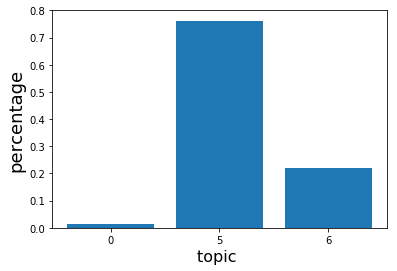

In [37]:
visulize_topic_dist('hjort_11_workid54096.txt')

## d. Find dominant topic in each sentence

Here we present the topic modeling results for each of the documents we have, and we extract the most popular topic for each document.

In [38]:
"""the following code will help to determine what topic a given document is about"""
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = row[0]
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        topic_num = row[0][0]
        prop_topic = row[0][1]
        wp = ldamodel.show_topic(topic_num)
        topic_keywords = ", ".join([word for word, prop in wp])
        sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [39]:
df_topic_sents_keywords = format_topics_sentences(lda_model, corpus=corpus, texts=data)

In [42]:

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,14.0,1.0000,"så, kan, kom, had, kund, hel, vild, tænk, nok,...",KRAFTTidligere udkom af samme ForfatterSyner ....
1,1,0.0,0.9998,"så, kom, sae, kund, gik, skuld, vild, kan, jen...",PE SVENDSEN OG HANS SØNGårdejer Lars Olsen løf...
2,2,6.0,0.8082,"så, kom, sae, kund, kan, gik, vild, tænk, skul...",HANS RÅSKOVKNUD HJORTØHANS RÅSKOVDET SCHUBOTHE...
3,3,6.0,0.9998,"så, kom, sae, kund, kan, gik, vild, tænk, skul...",DE DØDES LOVDER gik tre unge piger ned ad Vink...
4,4,8.0,0.9991,"så, kom, kund, helga, kan, skuld, vild, tænk, ...",KNUD HJORTØTO VERDENERDET SCHUBOTHESKE FORLAGJ...
5,5,6.0,0.6699,"så, kom, sae, kund, kan, gik, vild, tænk, skul...",FJENDERBOGHOLDER Valdemar Hernes satte med en ...
6,6,3.0,0.9995,"så, kom, kan, mer, bach, stor, musik, kund, he...",KNUD HJORTØUNDER DETSVINDENDE LYSNYT NORDISK F...
7,7,5.0,1.0000,"så, kom, mennesk, kan, kund, vild, gik, mand, ...",KNUD HJORTØDEN GULE KR0NNIKEKNUD HJORTØSYNER. ...
8,8,6.0,0.9057,"så, kom, sae, kund, kan, gik, vild, tænk, skul...",DRØMMEN OM KVINDENKNUD HJORTØSYNER. 1899.HJEMM...
9,9,5.0,0.7614,"så, kom, mennesk, kan, kund, vild, gik, mand, ...",FAUSTKNUD HJORTØSYNER. 1899.HJEMME FRA EGNEN. ...


## e. Find the most representative document for each topic

In [46]:
"""find the documents a given topic has contributed to the most and infer the topic by reading that document."""
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head()

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.9998,"så, kom, sae, kund, gik, skuld, vild, kan, jen...",PE SVENDSEN OG HANS SØNGårdejer Lars Olsen løf...
1,1.0,0.9188,"så, sae, kom, kund, gik, kan, lig, godt, lidt,...",SVUNDNE SOMRE OGGAMLE VINTREKNUD HJORTØSYNER. ...
2,2.0,0.9998,"sør, så, per, bered, laues, kom, kund, pe_woll...",SØREN SKRETTES HANDLERAska gje dæ no høvn — sa...
3,3.0,0.9995,"så, kom, kan, mer, bach, stor, musik, kund, he...",KNUD HJORTØUNDER DETSVINDENDE LYSNYT NORDISK F...
4,5.0,1.0000,"så, kom, mennesk, kan, kund, vild, gik, mand, ...",KNUD HJORTØDEN GULE KR0NNIKEKNUD HJORTØSYNER. ...


## f. Find topic distribution across documents

You need to understand the volume and distribution of topics in order to judge how widely it was discussed.

In [47]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]
topic_num_keywords= topic_num_keywords.drop_duplicates(subset=['Dominant_Topic', 'Topic_Keywords'])

#Merge the quitity into a single table by topic number
temp = pd.DataFrame(topic_counts).reset_index()
temp.columns = ['Dominant_Topic','Num_Documents']
temp2 = pd.DataFrame(topic_contribution).reset_index()
temp2.columns = ['Dominant_Topic','Perc_Documents']
temp3 = pd.merge(topic_num_keywords, temp, on="Dominant_Topic")
df_dominant_topics=pd.merge(temp3, temp2, on="Dominant_Topic")

# Show
df_dominant_topics.sort_values(by=['Perc_Documents']).reset_index()

,index,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0,0,14.0,"så, kan, kom, had, kund, hel, vild, tænk, nok,...",1,0.0286
1,4,3.0,"så, kom, kan, mer, bach, stor, musik, kund, he...",1,0.0286
2,6,1.0,"så, sae, kom, kund, gik, kan, lig, godt, lidt,...",1,0.0286
3,7,15.0,"sør, så, margret, kom, sae, kan, kund, karl, s...",1,0.0286
4,8,16.0,"herta, sae, kom, johan, kund, kan, jens, så, j...",1,0.0286
5,9,2.0,"sør, så, per, bered, laues, kom, kund, pe_woll...",1,0.0286
6,10,10.0,"så, had, kan, kom, sa, kund, nok, godt, hel, ha",1,0.0286
7,11,18.0,"så, kan, noet, kom, se, hel, digt, mennesk, ha...",1,0.0286
8,3,8.0,"så, kom, kund, helga, kan, skuld, vild, tænk, ...",2,0.0571
9,5,5.0,"så, kom, mennesk, kan, kund, vild, gik, mand, ...",3,0.0857
